<a href="https://colab.research.google.com/github/Taiba528/My-Python-World/blob/master/Turbofan_failure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 The goal of this project is to predict whether or not some turbofan engines are going to break down within the next 100 cycles. The dataset consists of different multivariate time-series. These different time-series refer to different engines ( engineno in the dataset). The sampling of the time series is 1 point per engine cycle ( timein_cycles in the dataset). The dataset is split into train data and test data to evaluate the model. In the train dataset: the engine runs until failure. It means that for each data point we can associate the RUL (Remaining Useful Life in cycles). This column is present in the train dataset (RUL). In the test dataset: The engine runs until a certain point. We need to predict  whether or not the engine is going to fail whithin the next 100 cycles. .

In [1]:
#Import neccesary libraries
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RandomizedSearchCV


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from random import randint, shuffle
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
from google.colab import files
uploaded=files.upload()

Saving train_data.csv to train_data.csv


In [5]:
df_train = pd.read_csv("train_data.csv")
df_train.head()

,engine_no,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,RUL
0,0,1,25.0074,0.6200,60.0,462.54,536.84,1256.52,1043.97,7.05,9.02,175.29,1915.47,8019.94,0.94,36.70,164.75,2028.38,7875.47,10.8850,0.02,306,1915,84.93,14.35,8.4712,NaN,NaN,NaN,NaN,NaN,NaN,339
1,0,2,35.0072,0.8413,100.0,449.44,555.44,1364.42,1128.75,5.48,8.00,194.71,2223.06,8361.86,1.03,41.78,183.67,2388.20,8073.12,9.2527,0.02,334,2223,100.00,14.88,8.9928,NaN,NaN,NaN,NaN,NaN,NaN,338
2,0,3,25.0053,0.6215,60.0,462.54,536.42,1265.94,1047.23,7.05,9.03,175.29,1915.49,8021.37,0.94,36.49,164.49,2028.40,7884.88,10.9054,0.02,307,1915,84.93,14.21,8.5107,NaN,NaN,NaN,NaN,NaN,NaN,337
3,0,4,42.0045,0.8407,100.0,445.00,549.41,1355.52,1115.81,3.91,5.72,138.92,2212.03,8319.14,1.02,41.78,130.67,2388.13,8093.08,9.3434,0.02,331,2212,100.00,10.63,6.4578,NaN,NaN,NaN,NaN,NaN,NaN,336
4,0,5,35.0046,0.8400,100.0,449.44,555.21,1361.04,1123.63,5.48,8.00,194.91,2223.10,8357.89,1.03,41.79,183.02,2388.19,8078.18,9.3287,0.02,334,2223,100.00,14.95,9.0279,NaN,NaN,NaN,NaN,NaN,NaN,335


In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [7]:
#Explore Data
df_train.shape
df_train.head()
df_train.tail()

(160359, 33)

,engine_no,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,RUL
0,0,1,25.0074,0.6200,60.0,462.54,536.84,1256.52,1043.97,7.05,9.02,175.29,1915.47,8019.94,0.94,36.70,164.75,2028.38,7875.47,10.8850,0.02,306,1915,84.93,14.35,8.4712,NaN,NaN,NaN,NaN,NaN,NaN,339
1,0,2,35.0072,0.8413,100.0,449.44,555.44,1364.42,1128.75,5.48,8.00,194.71,2223.06,8361.86,1.03,41.78,183.67,2388.20,8073.12,9.2527,0.02,334,2223,100.00,14.88,8.9928,NaN,NaN,NaN,NaN,NaN,NaN,338
2,0,3,25.0053,0.6215,60.0,462.54,536.42,1265.94,1047.23,7.05,9.03,175.29,1915.49,8021.37,0.94,36.49,164.49,2028.40,7884.88,10.9054,0.02,307,1915,84.93,14.21,8.5107,NaN,NaN,NaN,NaN,NaN,NaN,337
3,0,4,42.0045,0.8407,100.0,445.00,549.41,1355.52,1115.81,3.91,5.72,138.92,2212.03,8319.14,1.02,41.78,130.67,2388.13,8093.08,9.3434,0.02,331,2212,100.00,10.63,6.4578,NaN,NaN,NaN,NaN,NaN,NaN,336
4,0,5,35.0046,0.8400,100.0,449.44,555.21,1361.04,1123.63,5.48,8.00,194.91,2223.10,8357.89,1.03,41.79,183.02,2388.19,8078.18,9.3287,0.02,334,2223,100.00,14.95,9.0279,NaN,NaN,NaN,NaN,NaN,NaN,335


,engine_no,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,RUL
160354,708,159,10.0040,0.2519,100.0,489.05,605.81,1508.72,1333.13,10.52,15.50,393.88,2319.23,8883.57,1.26,45.85,370.25,2388.43,8217.81,8.7244,0.03,374,2319,100.00,28.48,16.8884,NaN,NaN,NaN,NaN,NaN,NaN,4
160355,708,160,10.0074,0.2500,100.0,489.05,605.83,1509.90,1328.53,10.52,15.50,392.90,2319.19,8883.37,1.26,46.07,370.29,2388.42,8219.37,8.7173,0.03,373,2319,100.00,28.20,16.9498,NaN,NaN,NaN,NaN,NaN,NaN,3
160356,708,161,34.9982,0.8400,100.0,449.44,556.62,1374.56,1145.17,5.48,8.01,193.42,2224.61,8452.80,1.02,42.42,183.04,2389.86,8155.94,9.3958,0.02,338,2223,100.00,14.76,8.9228,NaN,NaN,NaN,NaN,NaN,NaN,2
160357,708,162,24.9993,0.6219,60.0,462.54,537.58,1274.92,1064.82,7.05,9.03,175.23,1917.00,8098.70,0.93,37.23,163.75,2029.95,7954.31,11.0572,0.02,309,1915,84.93,14.05,8.3890,NaN,NaN,NaN,NaN,NaN,NaN,1
160358,708,163,42.0009,0.8400,100.0,445.00,550.51,1378.04,1146.93,3.91,5.72,138.38,2213.58,8422.65,1.03,42.78,130.65,2389.77,8181.74,9.4219,0.02,335,2212,100.00,10.33,6.1742,NaN,NaN,NaN,NaN,NaN,NaN,0


In [8]:
print ('Overall data summary')
df_train.describe()
df_train.shape

Overall data summary


,engine_no,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,RUL
count,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,0.0,0.0,0.0,0.0,0.0,0.0,160359.000000
mean,353.441665,123.331338,17.211973,0.410004,95.724344,485.840890,597.361022,1467.035653,1260.956434,9.894999,14.424935,359.729968,2273.829707,8677.553696,1.153705,44.212049,338.789821,2349.645243,8088.950972,9.054747,0.025185,360.698801,2273.754039,98.389146,25.942709,15.565700,NaN,NaN,NaN,NaN,NaN,NaN,122.331338
std,205.969348,83.538146,16.527988,0.367938,12.359044,30.420388,42.478516,118.175261,136.300073,4.265554,6.443922,174.133835,142.426613,374.657454,0.142103,3.426342,164.193480,111.167242,80.623257,0.751581,0.004997,31.021430,142.513114,4.656270,11.691422,7.015067,NaN,NaN,NaN,NaN,NaN,NaN,83.538146
min,0.000000,1.000000,-0.008700,-0.000600,60.000000,445.000000,535.480000,1242.670000,1023.770000,3.910000,5.670000,136.170000,1914.720000,7984.510000,0.930000,36.040000,128.310000,2027.570000,7845.780000,8.156300,0.020000,302.000000,1915.000000,84.930000,10.160000,6.010500,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,172.000000,57.000000,0.001300,0.000200,100.000000,449.440000,549.960000,1357.360000,1126.830000,5.480000,8.000000,175.710000,2212.120000,8334.770000,1.020000,42.010000,164.790000,2387.970000,8070.530000,8.439250,0.020000,332.000000,2212.000000,100.000000,14.330000,8.601300,NaN,NaN,NaN,NaN,NaN,NaN,56.000000
50%,355.000000,114.000000,19.998100,0.620000,100.000000,489.050000,605.930000,1492.810000,1271.740000,9.350000,13.660000,341.690000,2319.370000,8764.200000,1.090000,44.930000,321.690000,2388.070000,8118.590000,9.030100,0.030000,367.000000,2319.000000,100.000000,24.920000,14.953500,NaN,NaN,NaN,NaN,NaN,NaN,113.000000
75%,530.000000,173.000000,35.001500,0.840000,100.000000,518.670000,642.340000,1586.590000,1402.200000,14.620000,21.610000,553.290000,2388.050000,9055.850000,1.300000,47.340000,521.340000,2388.160000,8139.410000,9.344200,0.030000,392.000000,2388.000000,100.000000,38.820000,23.294600,NaN,NaN,NaN,NaN,NaN,NaN,172.000000
max,708.000000,543.000000,42.008000,0.842000,100.000000,518.670000,645.110000,1616.910000,1441.490000,14.620000,21.610000,570.810000,2388.640000,9244.590000,1.320000,48.530000,537.490000,2390.490000,8293.720000,11.066900,0.030000,400.000000,2388.000000,100.000000,39.890000,23.950500,NaN,NaN,NaN,NaN,NaN,NaN,542.000000


(160359, 33)

In [39]:
df_train.isna().sum

<bound method DataFrame.sum of         engine_no  time_in_cycles  ...    RUL  predict_test_lm
0           False           False  ...  False            False
1           False           False  ...  False            False
2           False           False  ...  False            False
3           False           False  ...  False            False
4           False           False  ...  False            False
...           ...             ...  ...    ...              ...
160354      False           False  ...  False            False
160355      False           False  ...  False            False
160356      False           False  ...  False            False
160357      False           False  ...  False            False
160358      False           False  ...  False            False

[160359 rows x 34 columns]>

In [10]:
from google.colab import files
uploaded=files.upload()

Saving test_data.csv to test_data.csv


In [11]:
df_test = pd.read_csv("test_data.csv")
df_test.head()

,engine_no,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27
0,0,1,42.0034,0.8400,100.0,445.00,549.36,1342.05,1124.56,3.91,5.71,138.59,2211.83,8311.68,1.02,41.93,130.98,2387.90,8077.78,9.3092,0.02,329,2212,100.0,10.69,6.3956,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,42.0017,0.8400,100.0,445.00,548.83,1351.93,1116.28,3.91,5.71,138.20,2211.79,8312.85,1.02,41.92,130.30,2387.89,8077.82,9.3450,0.02,331,2212,100.0,10.55,6.3775,NaN,NaN,NaN,NaN,NaN,NaN
2,0,3,0.0028,0.0019,100.0,518.67,642.35,1583.74,1400.44,14.62,21.61,554.46,2388.07,9052.16,1.30,47.43,521.83,2388.04,8129.19,8.3840,0.03,392,2388,100.0,38.85,23.3483,NaN,NaN,NaN,NaN,NaN,NaN
3,0,4,42.0047,0.8400,100.0,445.00,549.69,1354.36,1125.55,3.91,5.72,139.05,2211.81,8310.83,1.02,41.83,131.15,2387.82,8082.04,9.3852,0.02,330,2212,100.0,10.56,6.4871,NaN,NaN,NaN,NaN,NaN,NaN
4,0,5,10.0058,0.2506,100.0,489.05,604.72,1496.65,1310.52,10.52,15.49,394.71,2318.91,8760.80,1.26,45.25,371.57,2388.10,8121.73,8.6074,0.03,370,2319,100.0,28.78,17.1987,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
list_engine_no = list(df_train['engine_no'].drop_duplicates())
len(list_engine_no)

709

In [13]:
# retrieve the max cycles per engine: RUL
train_rul = pd.DataFrame(df_train.groupby('engine_no')['time_in_cycles'].max()).reset_index()
train_rul

,engine_no,time_in_cycles
0,0,340
1,1,322
2,2,161
3,3,253
4,4,184
...,...,...
704,704,262
705,705,213
706,706,275
707,707,224


# Split train - eval


In [14]:
ratio = .3
shuffle(list_engine_no)
engine_no_test = list_engine_no[:int(len(list_engine_no) * ratio)]
len(engine_no_test)


212

In [15]:
engine_no_train = [x for x in list_engine_no if x not in engine_no_test]
len(engine_no_train)


497

In [16]:
nan_column = df_train.columns[df_train.isna().any()].tolist()
const_columns = [c for c in df_train.columns if len(df_train[c].drop_duplicates()) <= 2]
print('Columns with all nan: \n' + str(nan_column) + '\n')
print('Columns with all const values: \n' + str(const_columns) + '\n')


Columns with all nan: 
['sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27']

Columns with all const values: 
['op_setting_3', 'sensor_16', 'sensor_19', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27']



In [17]:
metadata_columns = ['engine_no', 'time_in_cycles']
selected_features = [x for x in df_test.columns if x not in metadata_columns + nan_column + const_columns]
selected_features

['op_setting_1',
 'op_setting_2',
 'sensor_1',
 'sensor_2',
 'sensor_3',
 'sensor_4',
 'sensor_5',
 'sensor_6',
 'sensor_7',
 'sensor_8',
 'sensor_9',
 'sensor_10',
 'sensor_11',
 'sensor_12',
 'sensor_13',
 'sensor_14',
 'sensor_15',
 'sensor_17',
 'sensor_18',
 'sensor_20',
 'sensor_21']

In [0]:
data_train = df_train[df_train['engine_no'].isin(engine_no_train)]
data_eval = df_train[df_train['engine_no'].isin(engine_no_test)]

X_train, y_train = data_train[selected_features], data_train['RUL'] 

X_eval, y_eval = data_eval[selected_features], data_eval['RUL']

X_train_all, y_train_all = df_train[selected_features], df_train['RUL']

X_test = df_test[selected_features]

# Train the classifier

In [0]:
from sklearn.linear_model import LinearRegression
lm=LinearRegression()

In [20]:
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [21]:
predict_test_lm=lm.predict(X_eval)
predict_test_lm[0:5]

array([153.45467327, 135.23535211, 145.3330927 , 137.13652786,
       140.53635282])

In [22]:
print("R square value for regression test data is-")
np.round(lm.score(X_eval, y_eval)*100,2)

R square value for regression test data is-


55.57

In [23]:
from sklearn import metrics
print("simple linear regression Root Mean Square Error(RMSE) fro Test data:")
np.sqrt(metrics.mean_squared_error(y_eval,predict_test_lm))

simple linear regression Root Mean Square Error(RMSE) fro Test data:


55.602612546457244

# Train on all the dataset

In [24]:
lm.fit(X_train_all, y_train_all)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Make prediction

In [25]:
predict_test_lm=lm.predict(X_test)
np.round(predict_test_lm,decimals=0,)

array([179., 175., 162., ..., 104., 111., 112.])

In [0]:
df_train['predict_test_lm'] = lm.predict(X_train_all)
df_test['predict_test_lm'] = lm.predict(X_test)

# Make Decision

In [27]:
df_train = df_train.sort_values(['engine_no', 'time_in_cycles'])
df_test = df_test.sort_values(['engine_no', 'time_in_cycles'])

df_result = df_test.groupby('engine_no').last().reset_index()[['engine_no', 'predict_test_lm']]


df_result['result'] = df_result['predict_test_lm'].map(lambda x: 0 if x > 100 else 1)
df_result

,engine_no,predict_test_lm,result
0,0,69.109358,1
1,1,4.138363,1
2,2,179.665231,0
3,3,135.311474,0
4,4,34.619911,1
...,...,...,...
702,702,109.401383,0
703,703,117.930921,0
704,704,95.676304,1
705,705,99.926541,1


# Plotting the result

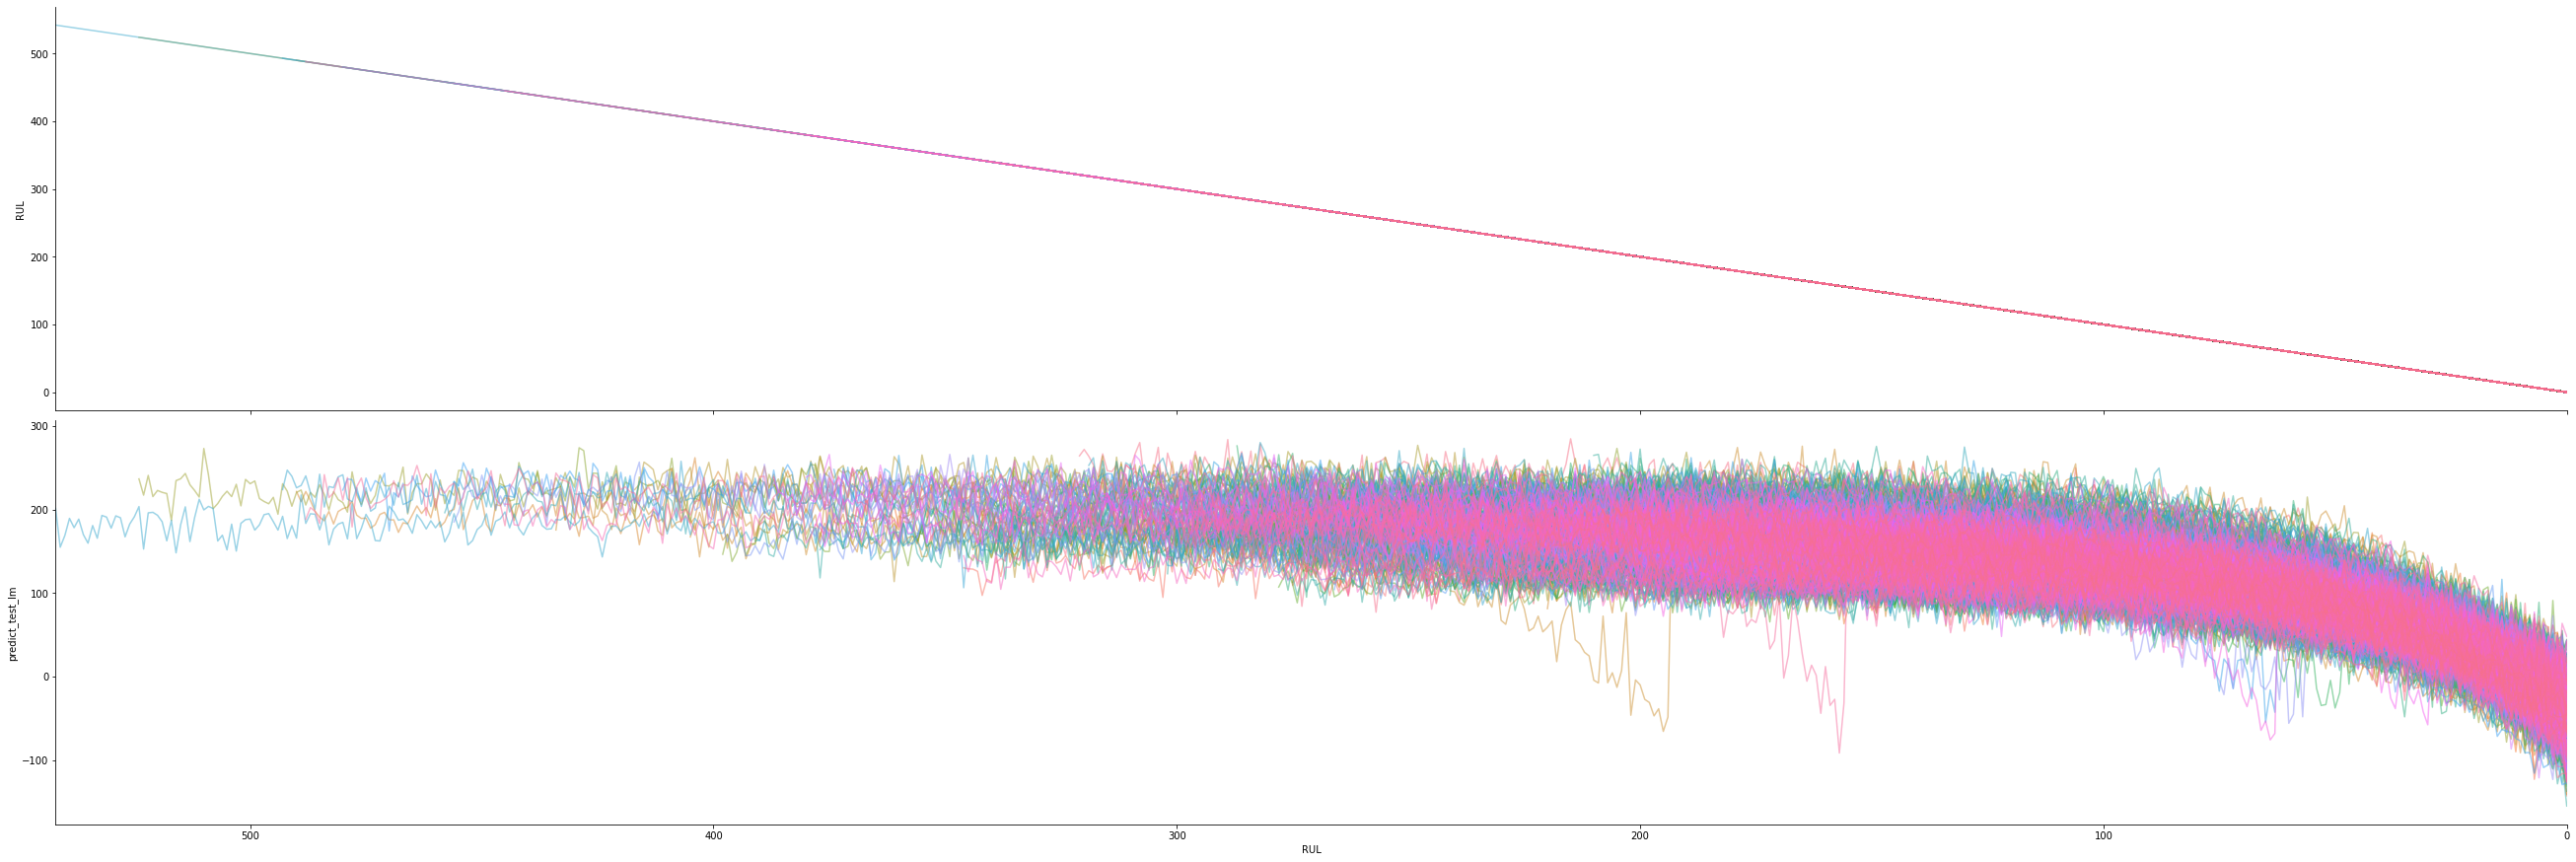

In [28]:
df_plot = df_train.copy()
df_plot = df_plot.sort_values(['engine_no', 'time_in_cycles'])
g = sns.PairGrid(data=df_plot, x_vars="RUL", y_vars=['RUL', 'predict_test_lm'], hue="engine_no", height=6, aspect=6,)
g = g.map(plt.plot, alpha=0.5)
g = g.set(xlim=(df_plot['RUL'].max(),df_plot['RUL'].min()))

In [29]:
df_result[['engine_no', 'result']].to_csv(r'C:\\Users\HP\Desktop\Turbofan failure\xyz.csv', index=True)
df1=df_result
df1.head()

,engine_no,predict_test_lm,result
0,0,69.109358,1
1,1,4.138363,1
2,2,179.665231,0
3,3,135.311474,0
4,4,34.619911,1


#DT model


In [0]:
#Building a DT model
from sklearn.tree import DecisionTreeClassifier
my_tree_one = DecisionTreeClassifier(max_depth=20)


In [0]:
#Fit the model instant on the training data using
my_tree_one = my_tree_one.fit(X_train, y_train)

In [32]:
#Predict using the model instant and training done on the training data using ‘ .predict() ‘ method 
predict_test = my_tree_one.predict(X_eval)
predict_test

array([ 61, 143, 146, ...,   2,   4,   4])

In [33]:
from sklearn.metrics import roc_curve,auc,recall_score,precision_score,accuracy_score,f1_score
from sklearn.metrics import confusion_matrix,average_precision_score,recall_score,classification_report
metrics = accuracy_score(predict_test,y_eval)
metrics 

0.015533209290657077

# Deep learning Model

In [34]:
X_train.shape,y_train.shape

((112526, 21), (112526,))

In [35]:
# Build Deep Learning Model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, advanced_activations
from keras.callbacks import ModelCheckpoint, TensorBoard

model = Sequential()
model.add(Dense(512, input_dim =21))
model.add(Activation('relu'))

model.add(Dense(256))
model.add(Activation('relu'))


model.add(Dense(128))
model.add(Activation('tanh'))
model.add(Dropout(0.2))

model.add(Dense(100))
model.add(Activation('tanh'))

model.add(Dense(10))
model.add(Activation('softmax'))
model.compile(optimizer='Adagrad', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Using TensorFlow backend.


In [36]:
# Fit the model
model.fit(X_train,y_train, epochs=10, batch_size=32)

Epoch 1/10


InvalidArgumentError: ignored